In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy.spatial
import functools
%matplotlib inline

## Kernel and Kernel Machines

In [3]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))

#Question 21-1
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors. 
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        rbf_matrix - matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    rbf_matrix = np.exp(scipy.spatial.distance.cdist(X1,X2,"sqeuclidean")/(-2*(sigma**2)))
    return rbf_matrix

#Question 21-2
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        poly_matrix - matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    poly_matrix = sklearn.metrics.pairwise.polynomial_kernel(X1, X2, degree=degree, gamma=1, coef0=offset)
    return poly_matrix


In [4]:
#Question 22: Compute the kernel matrix on the set of points x_0
X1 = np.array([-4, -1, 0, 2]).reshape(-1, 1)
X2 = np.array([-4, -1, 0, 2]).reshape(-1, 1)
rbf_matrix = linear_kernel(X1, X2)
print("The kernel matrix on the set of points [-4, -1, 0,2] is:")
print(rbf_matrix)

The kernel matrix on the set of points [-4, -1, 0,2] is:
[[16  4  0 -8]
 [ 4  1  0 -2]
 [ 0  0  0  0]
 [-8 -2  0  4]]


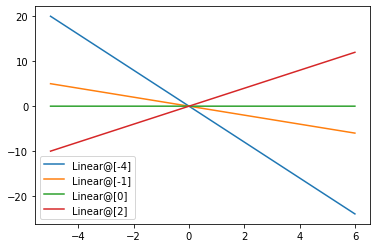

In [5]:
# Plot kernel machine functions
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

<function matplotlib.pyplot.show(close=None, block=None)>

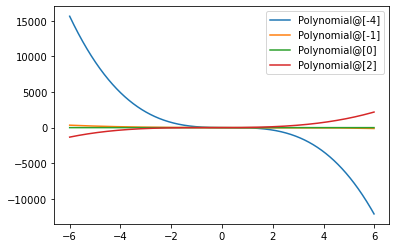

In [6]:
#Question 23-(a): Plot polynomial kernel machine functions
#Polynomial kernel
plot_step = .01
xpts = np.arange(-6, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

y = polynomial_kernel(prototypes, xpts, offset=1, degree=3)
for i in range(len(prototypes)):
    label = "Polynomial@" + str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc="best")
plt.show

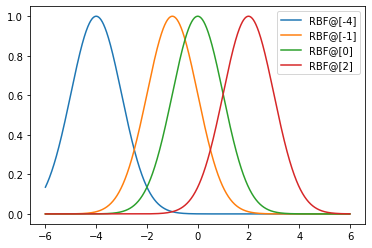

In [7]:
#Question 23-(b): Plot the RBF kernel machine function
#RBF kernel
y = RBF_kernel(prototypes, xpts, sigma=1)
for i in range(len(prototypes)):
    label = "RBF@" + str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc="best")
plt.show()

In [8]:
#Question 24
class Kernel_Machine():
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a matrix nx1 with entries alpha_1,...,alpha_n
        """
        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            f_X - Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        f_X = np.zeros((X.shape[0]))
        kernel_matrix = self.kernel(X, self.training_points)
        for i in range(X.shape[0]):
            f_X[i] = np.dot(self.weights.T, kernel_matrix[i,:])       
        return f_X                      

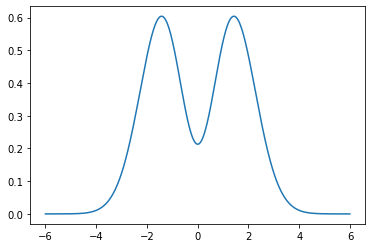

In [41]:
#Question 24
training_points = np.array([-1, 0, 1]).reshape(-1, 1)
weights = np.array([1, -1, 1]).reshape(-1,1)
X = np.arange(-6, 6, plot_step).reshape(-1,1)
#Construct a Kernel_Machine object with the RBF kernel
k = functools.partial(RBF_kernel, sigma=1)
rbf_kernel_machine = Kernel_Machine(k, training_points, weights)
#Plot the resulting function from
plt.plot(X, rbf_kernel_machine.predict(X))
plt.show()

## Kernel Ridge Regression: Practice

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [10]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

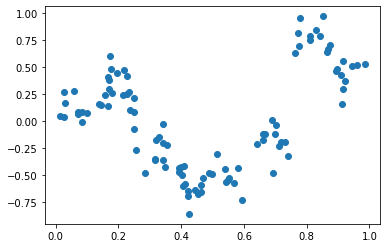

In [11]:
#Question 25
#Plot the training data
plt.scatter(x_train, y_train)

In [12]:
#Question 26
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    """
    Args:
        X - training points, an nxd matrix with inputs x_1, x_2, ...x_n in the rows
        y - vector of function values on the n points in X
        kernel(X1,X2) - a function returns the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
        l2reg - regularization paramater(lambda)
    Returns:
        Kernel_Machine(kernel, X, alpha) - a Kernel_Machine object that could be used for predicting on new points
    """
    n = X.shape[0]
    kernel_matrix = kernel(X, X)
    alpha = np.linalg.inv(l2reg*np.identity(n) + kernel_matrix)@y
    return Kernel_Machine(kernel, X, alpha)

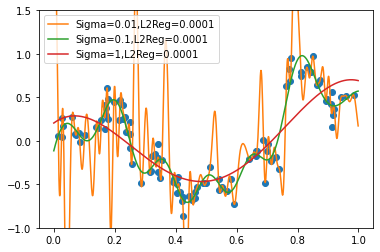

In [13]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

**Question 27:**
As we shall see from the figure above, when sigma=0.1, we got the best-fitting line; while when sigma=1, it is more likely to underfit and when sigma=0.01, it is more likely to overfit.

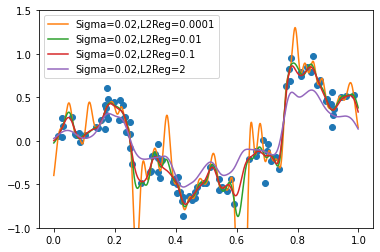

In [14]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

**Question 28:**
As we shall see from the figure above, the smaller the lambda is, the more volatile the fitting line is. When l2reg is 0.1 or 0.01, it is fitting better; when l2reg is 0.0001, it is more likely to overfit; and when l2reg is 2, it is more likely to underfit.

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [16]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)
#PredefinedSplit: Provides train/test indices to split data into train/test sets using a predefined scheme specified by the user with the test_fold parameter

In [17]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score=True
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidgeRegression(),
             param_grid=[{'kernel': ['RBF'],
                          'l2reg': array([32.    , 16.    ,  8.    ,  4.    ,  2.    ,  1.    ,  0.5   ,
        0.25  ,  0.125 ,  0.0625]),
                          'sigma': [0.1, 1, 10]},
                         {'degree': [2, 3, 4], 'kernel': ['polynomial'],
                          'l2reg': [10, 0.1, 0.01], 'offset': [-1, 0, 1]},
                         {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [18]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319
...,...,...,...,...,...,...,...
5,-,RBF,16.0000,-,10,0.167949,0.210743
2,-,RBF,32.0000,-,10,0.167995,0.210809
51,4,polynomial,0.1000,-1,-,0.188090,0.148359
30,2,polynomial,10.0000,-1,-,0.202746,0.239150


In [19]:
#Question 29: Find the best hyperparameter settings
#(1)Linear kernel
df_toshow[df_toshow["param_kernel"]=="linear"].sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
58,-,linear,1.00,-,-,0.164540,0.206506
59,-,linear,0.01,-,-,0.164569,0.206501
57,-,linear,10.00,-,-,0.164591,0.206780


In [20]:
#(2)RBF kernel
pd.set_option('display.max_rows', 30)
df_toshow[df_toshow["param_kernel"]=="RBF"].sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319
12,-,RBF,2.0000,-,0.1,0.028041,0.033539
9,-,RBF,4.0000,-,0.1,0.030082,0.039685
6,-,RBF,8.0000,-,0.1,0.037650,0.052373
3,-,RBF,16.0000,-,0.1,0.055006,0.075591
28,-,RBF,0.0625,-,1,0.063632,0.098843


In [21]:
#(3)Polynomial kernel
df_toshow[df_toshow["param_kernel"]=="polynomial"].sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
54,4,polynomial,0.01,-1,-,0.043454,0.060135
56,4,polynomial,0.01,1,-,0.060262,0.088844
33,2,polynomial,0.10,-1,-,0.065554,0.098913
38,2,polynomial,0.01,1,-,0.066532,0.097785
36,2,polynomial,0.01,-1,-,0.066915,0.097706
35,2,polynomial,0.10,1,-,0.067454,0.103356
44,3,polynomial,0.10,1,-,0.067508,0.097546
45,3,polynomial,0.01,-1,-,0.068156,0.097027
53,4,polynomial,0.10,1,-,0.068353,0.096693
42,3,polynomial,0.10,-1,-,0.068397,0.099992


In [22]:
# Can be a more convenient way to look at the table
import qgrid 
# qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

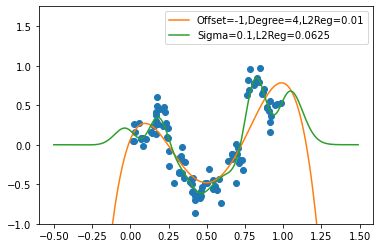

In [23]:
#Question 30
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')

#Plot best polynomial fit
offset= -1
degree = 4
l2reg = 0.01
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)

#Plot best RBF fit
sigma = 0.1
l2reg= 0.0625
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

**Question 30:**
As we could see from the figure above, using RBF kernel along with its best hyperparameter settings fits better than using polynomial kernel along with its best hyperparameter settings. 

# Kernel SVM

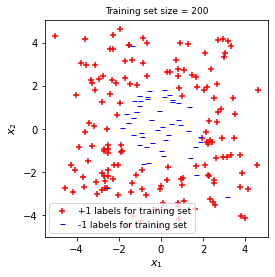

In [24]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [25]:
##Question 32
import pandas as pd
df = pd.DataFrame(x_train, columns=["Feature_1","Feature_2"])
df["Target"] = y_train
df.head()

,Feature_1,Feature_2,Target
0,-0.684465,1.325172,-1.0
1,-0.198445,-0.092779,-1.0
2,4.597847,1.788982,1.0
3,3.399398,1.432014,1.0
4,-2.515830,-1.885180,1.0


array([[<AxesSubplot:xlabel='Feature_1', ylabel='Feature_1'>,
        <AxesSubplot:xlabel='Feature_2', ylabel='Feature_1'>],
       [<AxesSubplot:xlabel='Feature_1', ylabel='Feature_2'>,
        <AxesSubplot:xlabel='Feature_2', ylabel='Feature_2'>]],
      dtype=object)

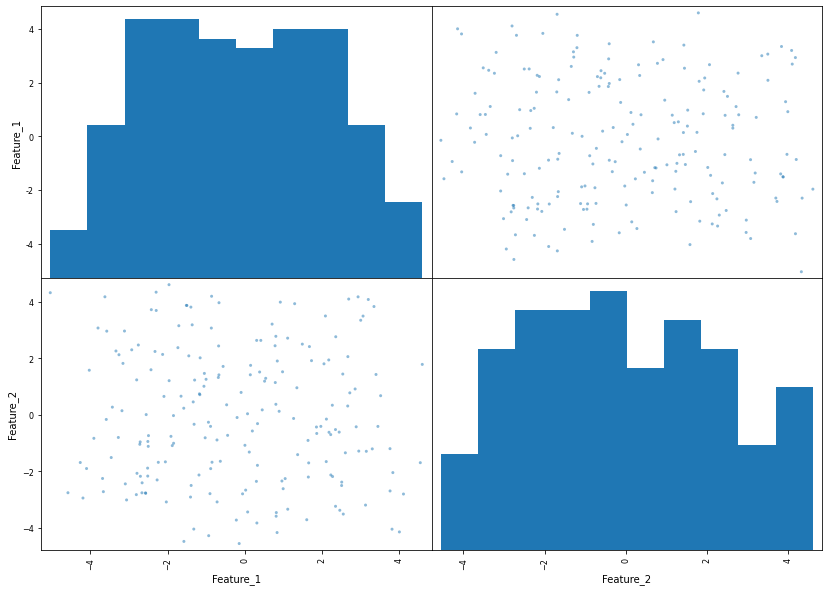

In [26]:
#Data Visualization
from pandas.plotting import scatter_matrix
scatter_matrix(df.iloc[:,0:2], figsize=(14,10))

**Note:** 
The scatter matrix above is a pair-wise scatter plot for all features in the dataset.
The scatter plot matrix provides insights into how these variables are correlated.

<Figure size 432x288 with 0 Axes>

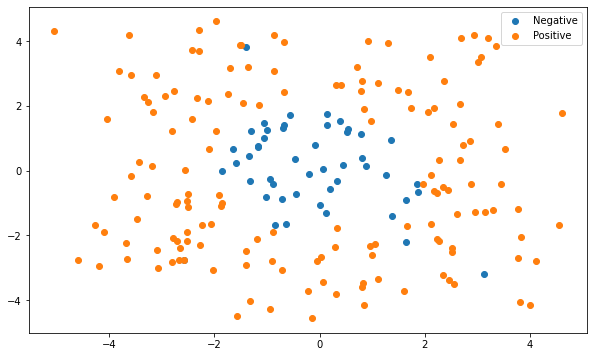

In [27]:
plt.clf()
plt.figure(figsize=(10,6))

bucket1 = df[df["Target"] == -1]
bucket1 = bucket1.iloc[:,[0,1]].values
plt.scatter(bucket1[:,0], bucket1[:,1], label="Negative")

bucket2 = df[df["Target"] == 1]
bucket2 = bucket2.iloc[:,[0,1]].values
plt.scatter(bucket2[:,0], bucket2[:,1], label="Positive")

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

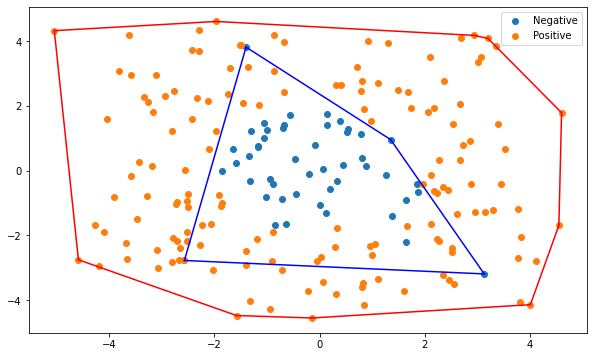

In [28]:
##Computational Geometry
#The logic when using convex hull when testing for linear separability is:
#Two classes X and Y are LS if the intersection of the convex hulls of X and Y is empty, and NLS 
#with a non-empty intersection.
from scipy.spatial import ConvexHull

plt.clf()
plt.figure(figsize=(10,6))

bucket1 = df[df["Target"] == -1]
bucket1 = bucket1.iloc[:,[0,1]].values
hull1 = ConvexHull(bucket1)
plt.scatter(bucket1[:,0], bucket1[:,1], label="Negative")
for i in hull1.simplices:
    plt.plot(bucket1[i,0], bucket1[i,1], color="b")

bucket2 = df[df["Target"] == 1]
bucket2 = bucket2.iloc[:,[0,1]].values
hull2 = ConvexHull(bucket2)
plt.scatter(bucket2[:,0], bucket2[:,1], label="Positive")
for i in hull2.simplices:
    plt.plot(bucket2[i,0], bucket2[i,1], color="r")

plt.legend()
plt.show()

**Note:** It is obvious now, visually at least, that Negative reviews and Positive reviews are not linearly separable because we can see there indeed exists an intersection.

/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


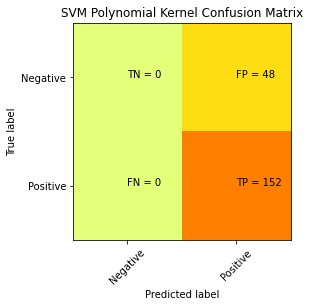

In [29]:
##Testing the quadratic separability with SVM
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
svm = SVC(C=0.001, kernel="poly", degree=2, random_state=0)
svm.fit(x_train, y_train)

predicted = svm.predict(x_train)
cm = confusion_matrix(y_train, predicted)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM Polynomial Kernel Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

**Note:** The confusion matrix indicates the classifier is not doing a good job at all, thus the data is not quadratically separable.

/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


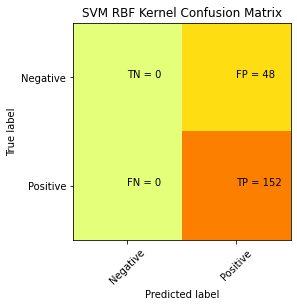

In [30]:
##Testing the separability RBF kernel
svm = SVC(C=0.001, kernel="rbf", random_state=0)
svm.fit(x_train, y_train)

predicted = svm.predict(x_train)
cm = confusion_matrix(y_train, predicted)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM RBF Kernel Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

**Note:** The confusion matrix indicates the classifier is not doing a good job at all, thus the data is not separable with RBF kernel.

In [31]:
#Question 34
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.svm import SVC

data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)
#PredefinedSplit: Provides train/test indices to split data into train/test sets using a predefined scheme specified by the user with the test_fold parameter

In [32]:
param_grid = [{'kernel': ['rbf'],'gamma':[.1,1,10],'C':[0.1, 1, 10]},
              {'kernel':['poly'],'coef0':[-1,0,1], 'degree':[2,3,4],'C':[0.1, 1, 10]},
              {'kernel':['linear'],'C':[0.1, 1, 10]}]
# kernel_svm_classifier = KernelSVM()
grid = GridSearchCV(SVC(random_state=42),
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(accuracy_score, greater_is_better = True),
                    return_train_score=True
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=42),
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'coef0': [-1, 0, 1],
                          'degree': [2, 3, 4], 'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'kernel': ['linear']}],
             return_train_score=True, scoring=make_scorer(accuracy_score))

In [33]:
pd.set_option('display.max_rows', 39)
df = pd.DataFrame(grid.cv_results_)
cols_to_keep = ["param_C", "param_degree", "param_kernel","param_coef0","param_gamma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_C,param_degree,param_kernel,param_coef0,param_gamma,mean_test_score,mean_train_score
11,0.1,4,poly,-1,-,0.53375,0.555
29,10.0,4,poly,-1,-,0.53750,0.560
20,1.0,4,poly,-1,-,0.53750,0.560
28,10.0,3,poly,-1,-,0.54750,0.540
19,1.0,3,poly,-1,-,0.54875,0.540
10,0.1,3,poly,-1,-,0.56250,0.545
27,10.0,2,poly,-1,-,0.58875,0.550
18,1.0,2,poly,-1,-,0.59000,0.560
9,0.1,2,poly,-1,-,0.61875,0.595
36,0.1,-,linear,-,-,0.78000,0.760


/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


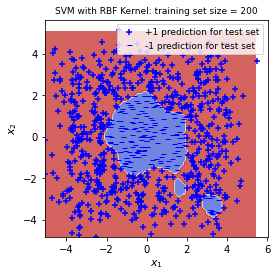

In [34]:
##Question 35
# # Code to help plot the decision regions
# # (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
##The best hyperparameter settings for RBF kernel
C = 10
gamma = 1
kernel = "rbf"
rbf_kernel_svm_classifier = SVC(kernel= kernel, C=C, gamma=gamma)
rbf_kernel_svm_classifier.fit(x_train, y_train)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = rbf_kernel_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = rbf_kernel_svm_classifier.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


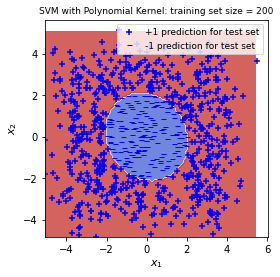

In [35]:
# # Code to help plot the decision regions
# # (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
##The best hyperparameter settings for Polynomial kernel
C = 1
degree = 2
kernel = "poly"
coef0 = 0
poly_kernel_svm_classifier = SVC(kernel=kernel, C=C, coef0=coef0, degree=degree)
poly_kernel_svm_classifier.fit(x_train, y_train)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = poly_kernel_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = poly_kernel_svm_classifier.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with Polynomial Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

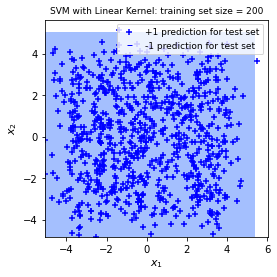

In [36]:
# # Code to help plot the decision regions
# # (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
##The best hyperparameter settings for Linear kernel
C = 10
kernel = "linear"
linear_kernel_svm_classifier = SVC(kernel=kernel, C=C)
linear_kernel_svm_classifier.fit(x_train, y_train.flatten())

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = linear_kernel_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = linear_kernel_svm_classifier.predict(x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter(xplus[:,:,0], xplus[:,:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter(xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with Linear Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()